In [1]:
from datetime import datetime
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

import subprocess
import pandas as pd

In [2]:
# elasticsearch instance
es = Elasticsearch('http://localhost:9200', verify_certs=False)

In [3]:
# scikit-learn repo
repo = 'https://github.com/scikit-learn/scikit-learn.git'

In [ ]:
# run p2o.py to get enriched indices
subprocess.run(['p2o.py', '--enrich', '--index', 'sklearn_raw', '--index-enrich', 'sklearn', '-e', 'http://localhost:9200', '--no_inc', '--debug', 'git', repo])

In [4]:
# frame a query
s = Search(using=es, index='sklearn')
s.aggs.bucket('by_authors', 'terms', field='author_name', size=15000).metric('first_commit', 'min', field='author_date')
s = s.sort('author_date')

# execute the query
result = s.execute()

In [5]:
buckets_result = result['aggregations']['by_authors']['buckets']
buckets = []

In [6]:
for bucket in buckets_result:
    # divide by milliseconds
    first_commit = bucket['first_commit']['value']/1000
    buckets.append({'first_commit':datetime.utcfromtimestamp(first_commit), 'author':bucket['key'], 'total_commits':bucket['doc_count']})

In [7]:
authors = pd.DataFrame.from_records(buckets)
authors

,author,first_commit,total_commits
0,Olivier Grisel,2010-03-03 13:46:28,2288
1,Andreas Mueller,2011-05-23 20:43:48,2093
2,Fabian Pedregosa,2010-01-05 13:26:32,1674
3,Lars Buitinck,2011-04-28 18:04:01,1283
4,Alexandre Gramfort,2010-03-02 15:01:46,1078
5,Gilles Louppe,2011-07-19 11:33:00,942
6,Gael Varoquaux,2010-01-08 08:35:18,886
7,Peter Prettenhofer,2010-10-19 00:00:25,868
8,Mathieu Blondel,2010-09-14 20:03:49,784
9,Gael varoquaux,2010-05-13 22:07:13,654


In [8]:
authors.sort_values(by='first_commit', ascending=False, inplace=True)
authors.index = range(len(authors))
authors.head()

In [11]:
by_month = authors[['first_commit', 'total_commits']].groupby([authors.first_commit.dt.year, authors.first_commit.dt.month]).agg(['min', 'max', 'count'])

In [12]:
by_month

first_commit                            \
                                          min                 max count   
first_commit first_commit                                                 
2010         1            2010-01-05 13:26:32 2010-01-08 08:35:18     2   
             2            2010-02-05 19:37:25 2010-02-05 19:37:25     1   
             3            2010-03-02 15:01:46 2010-03-24 21:07:28     5   
             5            2010-05-03 12:10:37 2010-05-13 22:07:13     4   
             6            2010-06-22 11:30:53 2010-06-22 11:30:53     1   
             7            2010-07-02 21:26:57 2010-07-27 23:49:52     5   
             8            2010-08-06 10:12:11 2010-08-18 17:12:52     3   
             9            2010-09-07 11:52:09 2010-09-18 22:47:59     5   
             10           2010-10-19 00:00:25 2010-10-19 14:02:31     2   
             11           2010-11-01 00:44:18 2010-11-30 18:16:48     6   
             12           2010-12-03 14:30:53 2010-12-16 12:34:54     3   
2011         1            2011-01-04 12:50:08 2011-01-20 19:03:23     7   
             2            2011-02-01 08:45:12 2011-02-14 16:27:38     2   
             3            2011-03-04 03:18:17 2011-03-31 10:30:57     4   
             4            2011-04-01 12:03:35 2011-04-28 18:04:01    15   
             5            2011-05-12 15:14:58 2011-05-23 20:43:48     6   
             6            2011-06-06 11:32:21 2011-06-18 08:17:03     4   
             7            2011-07-08 11:50:48 2011-07-31 18:34:18    12   
             8            2011-08-01 16:27:03 2011-08-30 16:05:57     7   
             9            2011-09-20 16:42:56 2011-09-25 18:02:11     3   
             10           2011-10-12 09:36:20 2011-10-12 09:36:20     1   
             11           2011-11-07 16:49:50 2011-11-28 02:24:55     2   
             12           2011-12-09 16:49:40 2011-12-24 13:22:36     5   
2012         1            2012-01-02 19:45:59 2012-01-27 15:24:36     7   
             2            2012-02-02 19:41:59 2012-02-23 23:39:18     6   
             3            2012-03-06 21:07:39 2012-03-26 12:17:15     8   
             4            2012-04-10 07:22:06 2012-04-26 18:33:43     4   
             5            2012-05-01 20:50:25 2012-05-31 09:36:31     8   
             6            2012-06-04 10:22:28 2012-06-28 11:16:52     4   
             7            2012-07-10 15:07:35 2012-07-25 11:34:04     6   
...                                       ...                 ...   ...   
2015         10           2015-10-01 12:05:59 2015-10-31 23:21:49    33   
             11           2015-11-02 18:38:27 2015-11-24 22:22:45    30   
             12           2015-12-03 00:16:43 2015-12-28 13:09:58    17   
2016         1            2016-01-01 13:18:18 2016-01-30 00:51:37    13   
             2            2016-02-06 01:14:26 2016-02-28 22:40:46     9   
             3            2016-03-01 06:26:52 2016-03-31 00:59:14    11   
             4            2016-04-02 14:58:40 2016-04-30 06:08:11    27   
             5            2016-05-03 14:52:32 2016-05-31 14:32:20    17   
             6            2016-06-01 14:26:25 2016-06-28 17:00:26    17   
             7            2016-07-01 15:50:40 2016-07-30 00:01:36    30   
             8            2016-08-02 12:36:43 2016-08-31 19:51:03    26   
             9            2016-09-05 14:45:57 2016-09-30 09:06:09    30   
             10           2016-10-01 16:23:55 2016-10-31 15:50:35    46   
             11           2016-11-01 22:29:34 2016-11-28 12:38:26    19   
             12           2016-12-01 10:23:38 2016-12-29 02:46:53    17   
2017         1            2017-01-03 13:32:09 2017-01-28 15:35:15    13   
             2            2017-02-01 17:43:12 2017-02-26 13:12:21    21   
             3            2017-03-02 08:54:09 2017-03-31 19:20:49    35   
             4            2017-04-06 23:42:34 2017-04-30 00:57:23    16   
             5            2017-05-08 17:02:38 2017-05-31 0

In [ ]:
by_month['first_commit']['count']

In [17]:
years = list(authors.first_commit.dt.year)
months = list(authors.first_commit.dt.month)

In [21]:
datestr = []
for i in range(len(authors)):
    if months[i] < 10:
        months[i] = str(0) + str(months[i])
    datestr.append(str(years[i]) + str(months[i]))

In [24]:
authors['datestr'] = pd.Series(datestr, index=authors.index)

In [51]:
authors = authors[['author', 'datestr', 'first_commit', 'total_commits']]
authors

,author,datestr,first_commit,total_commits
0,Kirill,201803,2018-03-02 08:32:42,2
1,Alexander-N,201803,2018-03-01 23:33:05,1
2,Adam Richie-Halford,201803,2018-03-01 14:27:26,1
3,Jan Schlüter,201803,2018-03-01 02:03:19,1
4,Will Rosenfeld,201802,2018-02-28 02:41:58,1
5,Saurabh Gupta,201802,2018-02-27 03:30:38,1
6,Trishnendu Ghorai,201802,2018-02-26 17:48:27,1
7,Danielle Shwed,201802,2018-02-26 17:25:20,1
8,Mohamed Ali Jamaoui,201802,2018-02-26 13:21:17,2
9,Chady Kamar,201802,2018-02-24 13:42:44,1


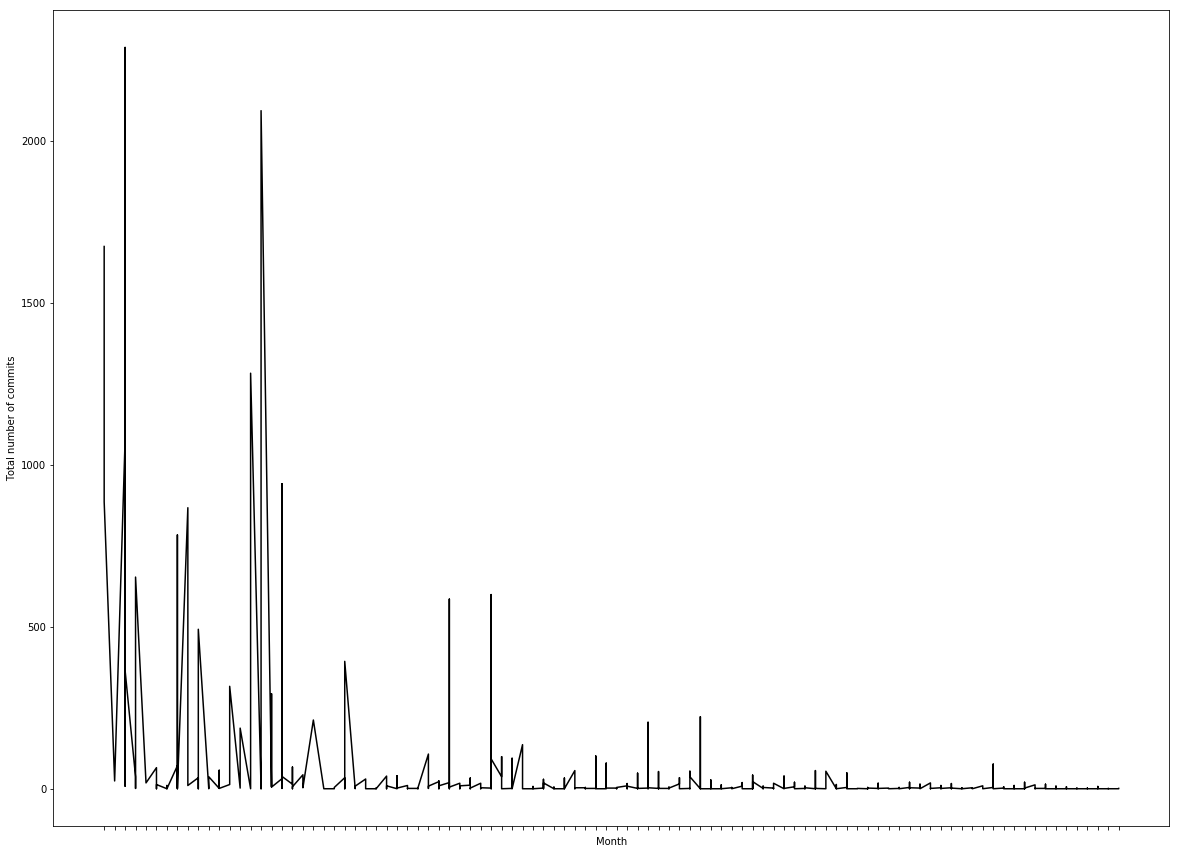

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(authors.datestr, authors.total_commits, 'k-')
ax.set_ylabel('Total number of commits')
ax.set_xlabel('Month')
ax.set_xticklabels([])
plt.show()